In [38]:
from PIL import Image
import binascii
import random

import numpy as np
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.backends import default_backend

In [39]:
THRESHOLD_CONSTANT = 4 #Number used to scale secret image to test if carry image can contain secret image
CARRY_IMAGE_FILE = "D:/Images/canyon1.png"
MESG_IMAGE_FILE = "D:/Images/hello.png"
MERGED_IMAGE_FILE = "D:/Images/merged.png"

In [40]:
#This tests each image in array format
#Provides feedback given lengths of array
#Good since dimensions doesn't really matter when hiding an image,
#   we need to know if we have enough pixels to hide the image, not necessarily
#   the dimensions
def img_cmp_arr(carry, message):

    carry_im = Image.open(carry)
    mesg_im = Image.open(message)

    carry_arr = list(carry_im.getdata())
    mesg_arr = list(mesg_im.getdata())

    carry_size = len(carry_arr)
    mesg_size = len(mesg_arr)

    if (carry_size > (THRESHOLD_CONSTANT*(mesg_size))):
        return True
    else:
        return False

In [41]:
def integer_to_binary(value):
    '''
    Convert R or G or B pixel values from integer to binary
    INPUT: An integer tuple (e.g. (220))
    OUTPUT: A string tuple (e.g. ("00101010"))
    '''
    return ('{0:08b}'.format(value))
            

In [42]:
def binary_to_integer(binary):
    '''
    Convert R or G or B pixel values from binary to integer.
    INPUT: A string tuple (e.g. ("00101010"))
    OUTPUT: Return an int tuple (e.g. (220))
    '''   
    return (int(binary, 2))

In [43]:
def to_array(image):
    
    image_arr = np.array(image)
    shape = image_arr.shape
    flat_arr = image_arr.ravel()

    return flat_arr, shape

In [44]:
def to_image(arr, img_shape):
    matrix = np.matrix(arr)

    reform_matrix = np.asarray(matrix).reshape(img_shape)

    new_img = Image.fromarray(reform_matrix, 'RGB')

    return new_img

In [45]:
def merge_pixels(pixel1, pixel2):
    '''
    Merge two R or G or B pixels using 4 least significant bits.
    INPUT: A string tuple (e.g. ("00101010")),
           Another string tuple (e.g. ("00101010"))
    OUTPUT: An integer tuple with the two RGB values merged 00100010
    '''
    
    merged_pixel = (pixel1[:4] + pixel2[:4])
    return merged_pixel

In [46]:
def get_seed(pass_code, salt):
    backend = default_backend()
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,  # 256 bits
        salt=salt,  # salt is 0x0000
        iterations=100000,
        backend=backend
    )
    return int(binascii.hexlify(kdf.derive(pass_code.encode())), 16)

In [47]:
def merge_images(carry_image_path, mesg_image_path, secret_key):
    '''
    Merge two images. The msegImage will be merged into the carryImage.
    INPUT: carry and message image path
    OUTPUT: A new merged image.
    '''   
    carry_image = Image.open(carry_image_path)
    message_image = Image.open(mesg_image_path)
        
    # Ensure carry image is larger than message image
    if not img_cmp_arr(carry_image_path,mesg_image_path):
       raise ValueError('Carry image size is lower than message image size!')
    
    # Create a new image that will be outputted
    new_image = Image.new(carry_image.mode, carry_image.size)
    new_image_arr = to_array(new_image)
        
    carry_arr = to_array(carry_image)
    mesg_arr = to_array(message_image)
    
    for i in range(len(carry_arr[0])):
        new_image_arr[0][i] = carry_arr[0][i]
    
    random.seed(secret_key)
    for i in range(len(mesg_arr[0])):
        # Check if the pixel count is valid for the second image
        if i < len(mesg_arr[0]):
            random_pixel = random.randint(0,len(carry_arr[0])-1)
            carry_pixel = integer_to_binary(carry_arr[0][random_pixel])
            mesg_pixel = integer_to_binary(mesg_arr[0][i])

            # Merge the two pixels and convert it to a integer tuple
            merged_pixel = merge_pixels(carry_pixel, mesg_pixel)

            new_image_arr[0][random_pixel] = binary_to_integer(merged_pixel)
    
    new_image = to_image(new_image_arr[0], new_image_arr[1])
    new_image.save('D:/Images/merged.png')
    
    return new_image
    
    

In [48]:
def extract_hidden_image(merged_image_path,mesg_image_path, secret_key):
    '''
    Unmerge an image.
    INPUT: The path to the input image.
    OUTPUT: The extracted hidden image.
    '''   
    merged_img = Image.open(merged_image_path)
    message_image = Image.open(mesg_image_path)

    # Create the new image and load the pixel map
    new_image = Image.new(message_image.mode, message_image.size)
    new_image_arr = to_array(new_image)

    # Tuple used to store the image original size
    original_size = len(new_image_arr[0])
    
    merged_arr = to_array(merged_img)
    mesg_arr = to_array(message_image)
    
    random.seed(secret_key)
    for i in range(len(mesg_arr[0])):
        random_pixel = random.randint(0,len(merged_arr[0])-1)
        binaryValue= integer_to_binary(merged_arr[0][random_pixel])

        # Extract the last 4 bits (corresponding to the hidden image)
        # Concatenate 4 zero bits because we are working with 8 bit values
        extractedBinary = (binaryValue[4:] + "0000")

        # Convert it to an integer tuple
        
        extractedInteger= binary_to_integer(extractedBinary)
        if  extractedInteger!= 0:
            new_image_arr[0][i] = extractedInteger
            original_size = (i + 1)

    hidden_image = to_image(new_image_arr[0], new_image_arr[1])
    
    hidden_image.save('D:/Images/unmerged.png')
    
    return hidden_image

In [49]:
secretKey= get_seed(pass_code="blah blah blah", salt=bytes(4))

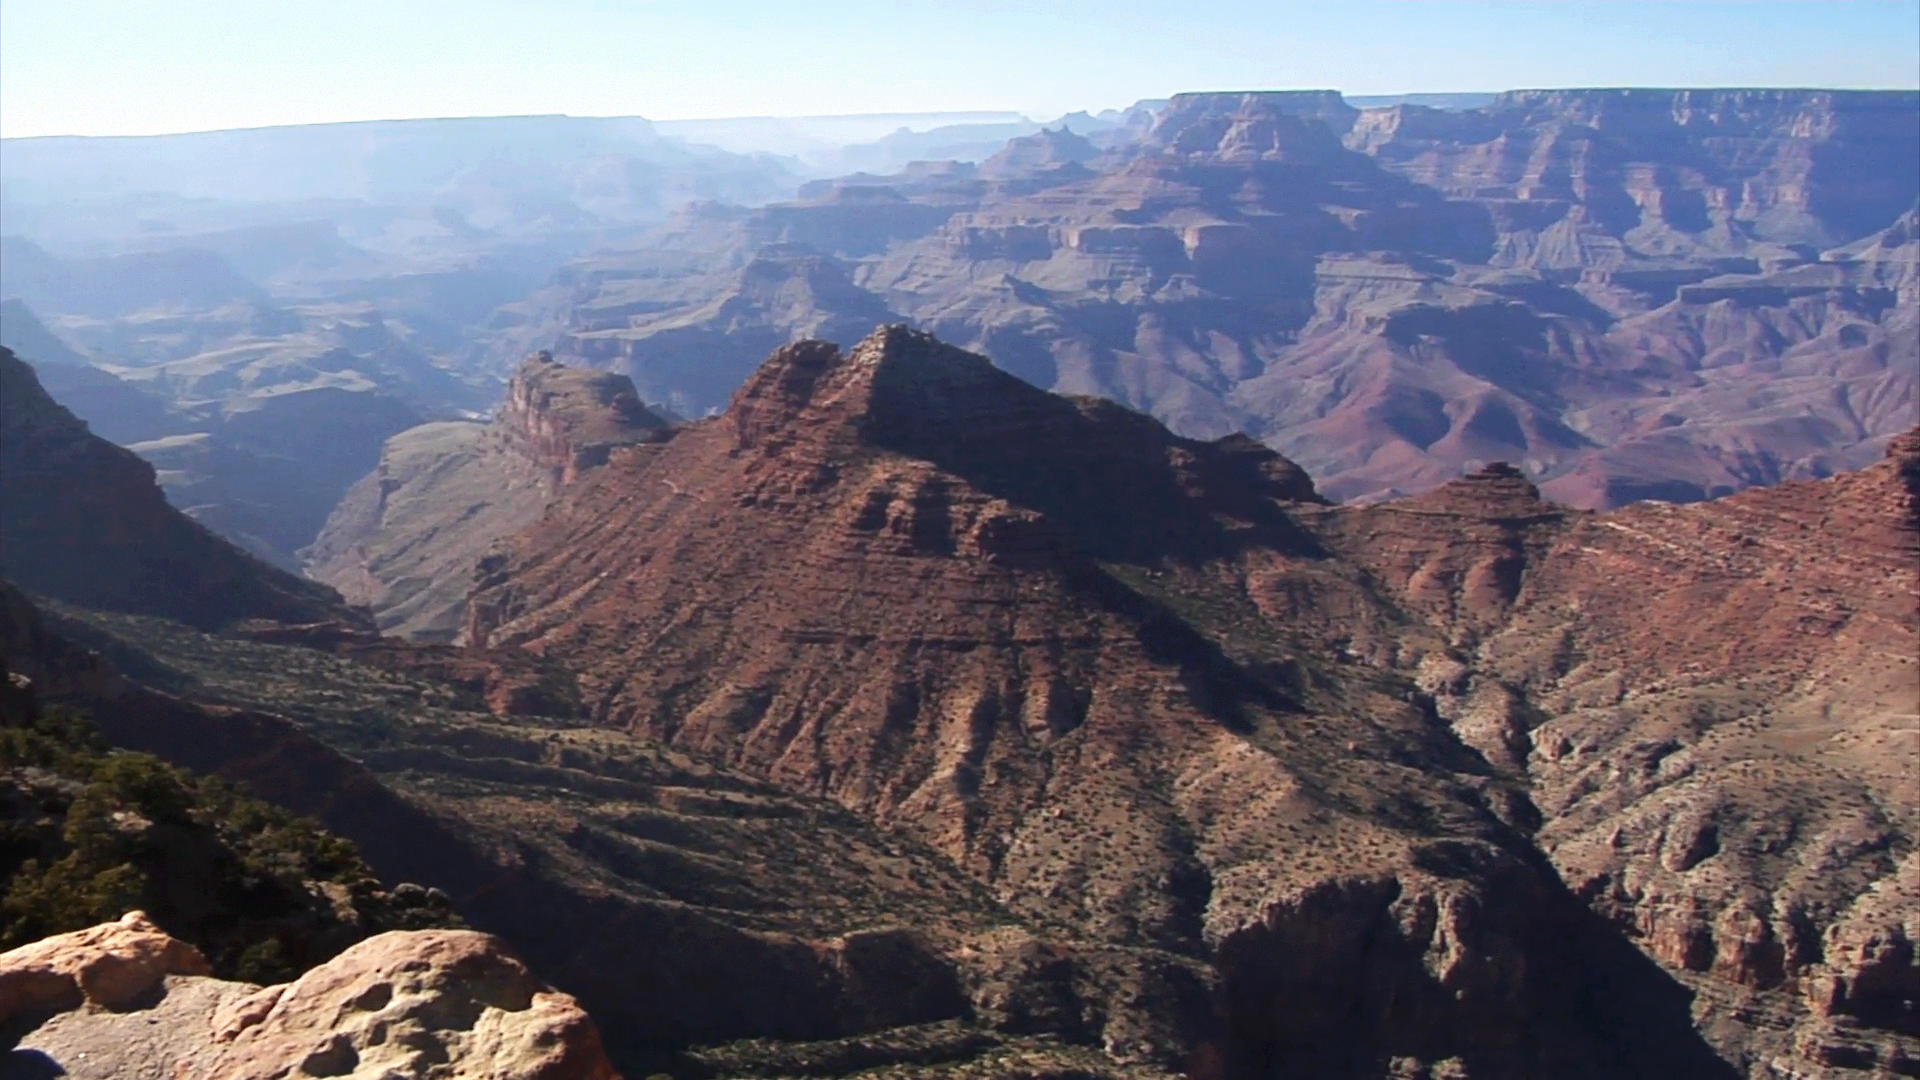

In [50]:
merged_image = merge_images(CARRY_IMAGE_FILE,MESG_IMAGE_FILE,secretKey)
merged_image

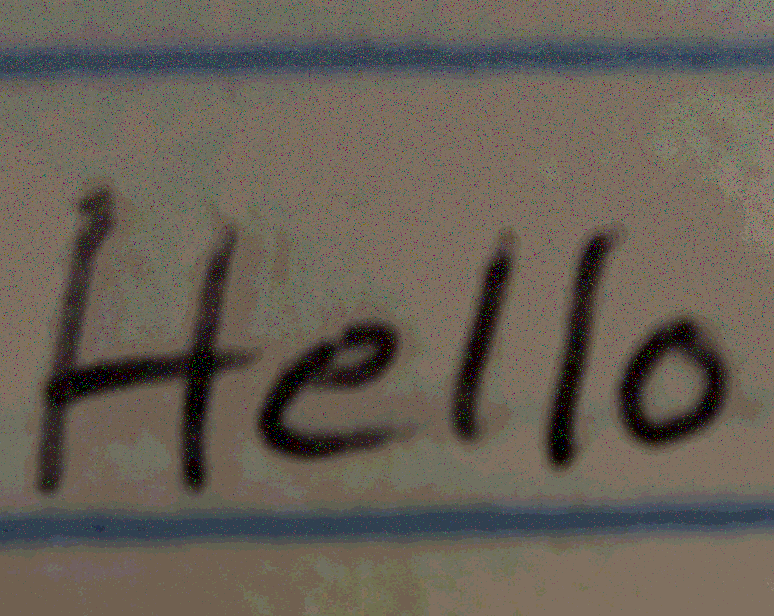

In [51]:
hidden_image = extract_hidden_image(MERGED_IMAGE_FILE,MESG_IMAGE_FILE,secretKey)
hidden_image